# Using the Discrete Wavelet Transform to classify signals

In [1]:
import numpy as np
import pandas as pd
import pywt
from collections import Counter
import scipy
import tqdm
from typing import List, Tuple
import matplotlib.pyplot as plt
from numpy import ndarray

### Data preprocessing

In [3]:
df = pd.read_parquet('train.parquet')
train_data = df.iloc[:,5:].values.reshape(663,24,2048).astype(np.float32)

(663, 24, 2048)

In [112]:
def dwt(train_data: np.ndarray, level: int = 2, wavelet: str = 'rbio1.3') -> np.ndarray:
    """
    Implementing discrete Wavelet transformation to deconstruct the signal of time series
    by retrieving approximation coefficients
    :param train_data: numpy ndarray
    :param level: Decomposition level
    :param wavelet: Wavelet function used to estimate coefficients
    :return: The new np.ndarray for the dataset transformed
    """
    data = None

    for sample in tqdm.tqdm(range(train_data.shape[0])):
        list_features = None

        for signal in range(train_data.shape[1]):
            # computing estimation of coefficient of the Wavelet transformation
            list_coeff = pywt.wavedec(train_data[sample,signal,:], wavelet=wavelet,mode='zero', level=level)
            coeff_features = None

            for coeff in list_coeff:
                if coeff_features is None:
                    # compute statistics w.r.t estimated coefficient given a specific level
                    coeff_features = get_features(coeff)
                else:
                    coeff_features = np.concatenate((coeff_features,get_features(coeff)))
            if list_features is None:
                list_features = coeff_features
            else:
                list_features = np.concatenate((list_features, coeff_features))
        if data is None:
            data = list_features[np.newaxis,]
        else:
            data = np.concatenate((data,list_features[np.newaxis,]), axis = 0)

    return np.array(data)




def get_features(list_values) -> np.ndarray:
    """
    :param list_values: list of detail coefficients and approximation coefficients for each time series
    :return summary stats
    """
    return np.array([
        np.mean(list_values),
        np.quantile(list_values,0.95),
        np.quantile(list_values,0.25),
        np.quantile(list_values,0.5),
        np.quantile(list_values,0.75),
        np.quantile(list_values,0.05),
        calculate_entropy(list_values)
        ])

def calculate_entropy(list_values: list) -> float:
    """
    Returning entropy value for a given list, it can be taken as a measure of complexity of the signal.
    :param list_values: list of detail coefficients and approximation coefficients for each time series
    :return The entropy for that given list as input
    """
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy


x_train  = dwt(train_data)

100%|██████████| 663/663 [00:31<00:00, 20.73it/s]


In [104]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [118]:
clf = make_pipeline(Normalizer(),SVC(class_weight='balanced',random_state=1234))
params = {
    'svc__C':np.linspace(0.1,1,10),
    'svc__decision_function_shape':['ovo'],
    'svc__kernel' :['linear','poly','rbf'],
    'svc__degree': [3,4,5],
    'svc__coef0': np.linspace(1,7,4),
    'svc__tol': np.linspace(0.1,3,4)
}
skf = StratifiedKFold(n_splits=3, shuffle=True)
cv = GridSearchCV(clf, param_grid=params,scoring='balanced_accuracy', n_jobs=-1, cv=skf.split(x_train, df.y),
                  return_train_score=True,refit=True)
cv.fit(x_train,df.y)
cv.best_score_,cv.best_params_

(0.6192596521145838,
 {'svc__C': 0.9,
  'svc__coef0': 1.0,
  'svc__decision_function_shape': 'ovo',
  'svc__degree': 4,
  'svc__kernel': 'poly',
  'svc__tol': 1.0666666666666667})

In [119]:
pd.DataFrame(cv.cv_results_).sort_values(by='mean_test_score',ascending=False).set_index('mean_train_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__coef0,param_svc__decision_function_shape,param_svc__degree,param_svc__kernel,param_svc__tol,...,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,std_train_score
mean_train_score,,,,,,,,,,,,,,,,,,,,,
0.933454,0.075204,0.024895,0.023309,0.004563,0.9,1.0,ovo,4,poly,1.066667,...,0.831537,0.337793,0.688449,0.619260,0.207423,1,0.931583,0.944403,0.924378,0.008282
0.899384,0.061583,0.001628,0.022339,0.001515,0.4,1.0,ovo,4,poly,0.1,...,0.813824,0.334448,0.683595,0.610622,0.202392,2,0.896163,0.895263,0.906726,0.005205
0.887018,0.084699,0.014680,0.026538,0.002695,0.9,1.0,ovo,3,poly,0.1,...,0.815434,0.313514,0.697909,0.608952,0.214345,3,0.892935,0.873471,0.894649,0.009605
0.886481,0.089132,0.019263,0.027604,0.004263,0.3,1.0,ovo,4,poly,0.1,...,0.815434,0.316735,0.693055,0.608408,0.212209,4,0.892935,0.873471,0.893039,0.009200
0.932164,0.055286,0.014471,0.019805,0.004295,1.0,3.0,ovo,3,poly,1.066667,...,0.809117,0.389199,0.626089,0.608135,0.171900,5,0.921990,0.941268,0.933234,0.007906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.443837,0.118151,0.044158,0.056645,0.024207,0.2,1.0,ovo,3,linear,0.1,...,0.333333,0.070606,0.322006,0.241982,0.121269,1429,0.431624,0.411964,0.487923,0.032190
0.443837,0.159481,0.065359,0.050987,0.013090,0.2,5.0,ovo,3,linear,0.1,...,0.333333,0.070606,0.322006,0.241982,0.121269,1429,0.431624,0.411964,0.487923,0.032190
0.443837,0.105702,0.008873,0.047708,0.017003,0.2,7.0,ovo,4,linear,0.1,...,0.333333,0.070606,0.322006,0.241982,0.121269,1429,0.431624,0.411964,0.487923,0.032190


### Submission

In [102]:
df_sub = pd.read_csv('test.csv')
X_sub = dwt(df_sub.iloc[:,4:].values.reshape(355,24,2048))

100%|██████████| 355/355 [00:16<00:00, 22.17it/s]


In [116]:
y_sub = cv.predict(X_sub)
submission_df = pd.DataFrame(y_sub,columns=['y'])
submission_df['id'] = df_sub.id
submission_df.set_index('id', inplace=True)
# submission_df.y = submission_df.y
submission_df.to_csv('submission1_3_04.csv')

Histogram of the distribution of the predicted labels for the test dataset

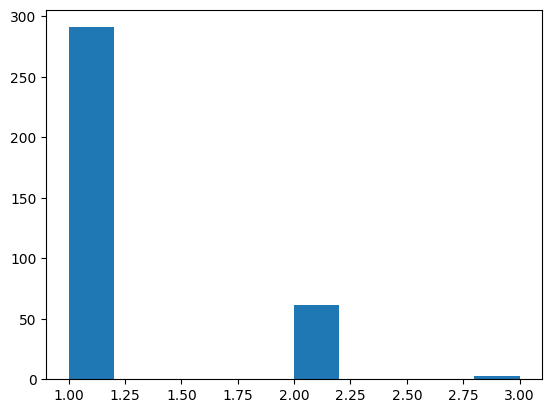

In [120]:
plt.hist(y_sub)
plt.show()